In [1]:
import sys 
sys.path.append('/data/conghao001/diffusion_model/latent-diffusion')
sys.path.append('../')

In [2]:
# set this before importing torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd

In [3]:
from moler_ldm import LatentDiffusion
import torch
from dataset import LincsDataset, MolerDataset
from torch_geometric.loader import DataLoader
from omegaconf import OmegaConf
from model_utils import get_params
from tqdm import tqdm
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from datetime import datetime
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like



2023-09-10 19:16:42.296856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.drawOptions.baseFontSize = 0.5
IPythonConsole.ipython_useSVG=True

In [5]:
device = torch.device("cuda:0")

# Unconditional VAE model

In [4]:
ckpt_path = 'lightning_logs/2023-05-04_12_17_02.544383/epochepoch=97-dropout=0.95-val_lossval/loss=0.35.ckpt'
checkpoint = torch.load(ckpt_path, map_location = device)
checkpoint

{'epoch': 97,
 'global_step': 77812,
 'pytorch-lightning_version': '1.8.1',
 'state_dict': OrderedDict([('betas',
               tensor([0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010,
                       0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013,
                       0.0013, 0.0014, 0.0014, 0.0014, 0.0014, 0.0015, 0.0015, 0.0015, 0.0016,
                       0.0016, 0.0016, 0.0017, 0.0017, 0.0017, 0.0018, 0.0018, 0.0018, 0.0019,
                       0.0019, 0.0019, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0022, 0.0022,
                       0.0022, 0.0023, 0.0023, 0.0024, 0.0024, 0.0024, 0.0025, 0.0025, 0.0026,
                       0.0026, 0.0026, 0.0027, 0.0027, 0.0028, 0.0028, 0.0029, 0.0029, 0.0029,
                       0.0030, 0.0030, 0.0031, 0.0031, 0.0032, 0.0032, 0.0033, 0.0033, 0.0033,
                       0.0034, 0.0034, 0.0035, 0.0035, 0.0036, 0.0036, 0.0037, 0.0037, 0.0038,
                       0.0038, 

In [5]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [6]:
checkpoint['callbacks']

{"EarlyStopping{'monitor': 'val/loss_simple_ema', 'mode': 'min'}": {'wait_count': 0,
  'stopped_epoch': 0,
  'best_score': tensor(0.3516, device='cuda:2'),
  'patience': 10},
 "ModelCheckpoint{'monitor': 'val/loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': True}": {'monitor': 'val/loss',
  'best_model_score': tensor(0.3511, device='cuda:2'),
  'best_model_path': '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383/epochepoch=97-dropoutargs.gen_step_drop_probability=0.00-val_lossval/loss=0.35.ckpt',
  'current_score': tensor(0.3511, device='cuda:2'),
  'dirpath': '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383',
  'best_k_models': {'/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383/epochepoch=97-dropoutargs.gen_step_drop_probability=0.00-val_lossval/loss=0.35.ckpt': tensor(0.3511, device='cuda:2')},
  'kth_best_model_p

In [7]:
config_file = '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383/logs_2023-05-04_12_17_02.544383/version_0/ddim_vae_uncon.yml'
config = OmegaConf.load(config_file)
ldm_params = config['model']['params']


In [8]:
# args
batch_size = 1
NUM_WORKERS = 4
train_split1 = "train_0"
valid_split = "valid_0"

layer_type = "FiLMConv"
model_architecture = 'vae'
gradient_clip_val = 1.0
max_lr = 1e-5
gen_step_drop_probability = 0
use_oclr_scheduler = True
using_cyclical_anneal = False
use_clamp_log_var = False

raw_moler_trace_dataset_parent_folder = "/data/ongh0068/guacamol/trace_dir"
# raw_moler_trace_dataset_parent_folder = "/data/ongh0068/l1000/TRACE_DIR"
output_pyg_trace_dataset_parent_folder = (
    "/data/ongh0068/l1000/already_batched"
)

In [9]:
dataset = LincsDataset(
    root="/data/ongh0068",
    raw_moler_trace_dataset_parent_folder="/data/ongh0068/guacamol/trace_dir",
    output_pyg_trace_dataset_parent_folder="/data/ongh0068/l1000/already_batched",
    split="valid_0",
    gene_exp_controls_file_path="/data/ongh0068/l1000/lincs/robust_normalized_controls.npz",
    gene_exp_tumour_file_path="/data/ongh0068/l1000/lincs/robust_normalized_tumors.npz",
    lincs_csv_file_path="/data/ongh0068/l1000/lincs/experiments_filtered.csv",
)

Loading controls gene expression...
Loading tumour gene expression...
Loading csv...


In [10]:
dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        # sampler=train_sampler,
        follow_batch=[
            "correct_edge_choices",
            "correct_edge_types",
            "valid_edge_choices",
            "valid_attachment_point_choices",
            "correct_attachment_point_choice",
            "correct_node_type_choices",
            "original_graph_x",
            "correct_first_node_type_choices",
        ],
        num_workers=NUM_WORKERS,
        # prefetch_factor=0,
    )

In [11]:
one = next(iter(dataloader))
one

MolerDataBatch(x=[16413, 59], edge_index=[2, 33312], original_graph_edge_features=[65434], original_graph_node_categorical_features=[29966], focus_node=[1000], partial_graph_edge_features=[33312], edge_features=[7327, 3], correct_edge_choices=[7327], correct_edge_choices_batch=[7327], correct_edge_choices_ptr=[1001], num_correct_edge_choices=[1000], stop_node_label=[1000], valid_edge_choices=[7327, 2], valid_edge_choices_batch=[7327], valid_edge_choices_ptr=[1001], valid_edge_types=[512, 3], correct_edge_types=[512, 3], correct_edge_types_batch=[512], correct_edge_types_ptr=[1001], partial_node_categorical_features=[16413], correct_attachment_point_choice=[58], correct_attachment_point_choice_batch=[58], correct_attachment_point_choice_ptr=[1001], correct_node_type_choices=[468, 166], correct_node_type_choices_batch=[468], correct_node_type_choices_ptr=[1001], correct_first_node_type_choices=[1000, 166], correct_first_node_type_choices_batch=[1000], correct_first_node_type_choices_ptr=

In [12]:
first_stage_params = get_params(dataset)
first_stage_config = config['model']['first_stage_config']
ldm_params = config['model']['params']
unet_params = config['model']['unet_config']['params']
unet_params

{'image_size': 512, 'in_channels': 1, 'out_channels': 1, 'model_channels': 64, 'dims': 1, 'attention_resolutions': [4, 2], 'num_res_blocks': 1, 'channel_mult': [1, 2, 3], 'num_head_channels': 8}

In [13]:
first_stage_params['latent_repr_size']

512

In [14]:
ldm_model = LatentDiffusion(
    first_stage_config,
    config['model']['cond_stage_config'],
    dataset, 
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config['model']['unet_config'],
    **ldm_params
)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 3.49 M params.


In [15]:
ldm_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [16]:
class MolSampler(DDIMSampler):
    def __init__(self, model, schedule="linear", **kwargs):
        super().__init__(model, schedule)
        
    @torch.no_grad()
    def sample(self,
               S,
               batch_size,
               shape,
               conditioning=None,
               callback=None,
               normals_sequence=None,
               img_callback=None,
               quantize_x0=False,
               eta=0.,
               mask=None,
               x0=None,
               temperature=1.,
               noise_dropout=0.,
               score_corrector=None,
               corrector_kwargs=None,
               verbose=True,
               x_T=None,
               log_every_t=100,
               unconditional_guidance_scale=1.,
               unconditional_conditioning=None,
               # this has to come in the same format as the conditioning, # e.g. as encoded tokens, ...
               **kwargs
              ):
        if conditioning is not None:
            if isinstance(conditioning, dict):
                cbs = conditioning[list(conditioning.keys())[0]].shape[0]
                if cbs != batch_size:
                    print(f"Warning: Got {cbs} conditionings but batch-size is {batch_size}")
            else:
                if conditioning.shape[0] != batch_size:
                    print(f"Warning: Got {conditioning.shape[0]} conditionings but batch-size is {batch_size}")

        self.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)
        # sampling
#         C, H, W = shape    
#         size = (batch_size, C, H, W)
        C, H = shape    # our latent repr is 1d
        size = (batch_size, C, H)
        
        print(f'Data shape for DDIM sampling is {size}, eta {eta}')

        samples, intermediates = self.ddim_sampling(conditioning, size,
                                                    callback=callback,
                                                    img_callback=img_callback,
                                                    quantize_denoised=quantize_x0,
                                                    mask=mask, x0=x0,
                                                    ddim_use_original_steps=False,
                                                    noise_dropout=noise_dropout,
                                                    temperature=temperature,
                                                    score_corrector=score_corrector,
                                                    corrector_kwargs=corrector_kwargs,
                                                    x_T=x_T,
                                                    log_every_t=log_every_t,
                                                    unconditional_guidance_scale=unconditional_guidance_scale,
                                                    unconditional_conditioning=unconditional_conditioning,
                                                    )
        return samples, intermediates
    
    @torch.no_grad()
    def p_sample_ddim(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None):
        b, *_, device = *x.shape, x.device

        if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
#             print('x shape', x.size())
            e_t = self.model.apply_model(x, t, c)
        else:
            x_in = torch.cat([x] * 2)
            t_in = torch.cat([t] * 2)
            c_in = torch.cat([unconditional_conditioning, c])
            e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
            e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)

        if score_corrector is not None:
            assert self.model.parameterization == "eps"
            e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

        alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
        alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
        sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
        sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas
        # select parameters corresponding to the currently considered timestep
        '''a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index],device=device)'''
        a_t = torch.full((b, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1), sqrt_one_minus_alphas[index],device=device)

        # current prediction for x_0
        pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
        if quantize_denoised:
            pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
        # direction pointing to x_t
        dir_xt = (1. - a_prev - sigma_t**2).sqrt() * e_t
        noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
        return x_prev, pred_x0
        

In [17]:
sampler = MolSampler(ldm_model)
sampler

In [25]:
# DDIM Sampler args
ddim_steps = 50
size = [unet_params.in_channels, unet_params.image_size]
n_samples = 1000
ddim_eta = 1.0

size

[1, 512]

In [26]:
samples, _ = sampler.sample(
    S = ddim_steps,
    batch_size = n_samples,  # not batch size
    shape = size,
    ddim_eta = ddim_eta
)

samples

Selected timesteps for ddim sampler: [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9946, 0.9904, 0.9859, 0.9810, 0.9756, 0.9698, 0.9635, 0.9568,
        0.9496, 0.9418, 0.9336, 0.9249, 0.9157, 0.9060, 0.8958, 0.8851, 0.8739,
        0.8622, 0.8500, 0.8373, 0.8241, 0.8105, 0.7964, 0.7819, 0.7670, 0.7516,
        0.7359, 0.7198, 0.7034, 0.6867, 0.6697, 0.6524, 0.6350, 0.6173, 0.5994,
        0.5814, 0.5633, 0.5451, 0.5269, 0.5087, 0.4905, 0.4724, 0.4543, 0.4364,
        0.4186, 0.4011, 0.3837, 0.3666, 0.3497]); a_(t-1): [0.99914998 0.99827701 0.99455011 0.99043489 0.98591566 0.98097759
 0.97560668 0.96978998 0.96351564 0.95677292 0.9495523  0.9418456
 0.93364584 0.92494762 0.91574699 0.90604162 0.89583057 0.88511467
 0.8738966  0.86218047 0.84997231 0.83727998 0.82411301 0.810

DDIM Sampler: 100%|█████████████████████████████████| 50/50 [09:03<00:00, 10.88s/it]


tensor([[[ 1.8279,  0.6690, -0.6795,  ...,  0.6101,  0.0247,  0.9151]],

        [[-0.6260,  0.3324,  1.2893,  ...,  1.1395, -0.4524, -0.5089]],

        [[-0.7755,  2.5129,  0.4428,  ..., -0.6935,  1.2498,  0.2269]],

        ...,

        [[-0.2326,  1.0207, -0.5788,  ..., -1.1407, -0.7831, -1.2441]],

        [[-0.1759, -0.1029,  0.4051,  ..., -0.1807, -1.3635,  0.6645]],

        [[ 0.4231,  0.6005, -0.0151,  ...,  0.1327,  0.6068,  0.9068]]])

In [27]:
samples.size()

torch.Size([1000, 1, 512])

In [21]:
batch = one

In [22]:
ldm_model.get_input(one)

[tensor([[[ 0.4734, -1.4087,  0.1958,  ...,  1.5560, -0.9406, -1.7449]],
 
         [[ 0.4683, -1.4139,  0.1947,  ...,  1.5533, -0.9355, -1.7543]],
 
         [[ 0.3031,  1.0340, -0.0407,  ...,  0.4056, -0.3836, -0.6014]],
 
         ...,
 
         [[-0.2114, -0.2411, -0.6172,  ...,  0.1160,  0.6226,  0.9216]],
 
         [[-0.1879, -0.2177, -0.6242,  ...,  0.0977,  0.6156,  0.8996]],
 
         [[-0.2164, -0.2129, -0.6224,  ...,  0.1158,  0.6235,  0.9164]]]),
 None]

In [23]:
# this is the input molecular representation (not the latent repr!!)

# z, _, _ = ldm_model.encode_first_stage(one)
z = ldm_model.first_stage_model._full_graph_encoder(
        original_graph_node_categorical_features=batch.original_graph_node_categorical_features,
        node_features=batch.original_graph_x.float(),
        edge_index=batch.original_graph_edge_index,
        edge_features=batch.original_graph_edge_features.float(),
        batch_index=batch.original_graph_x_batch,
    )

z.shape

torch.Size([1000, 832])

## Problems (solved)
- The original decode function (from Abstract model) has a shape of 512, not 832
- The decoder in Base VAE model has input such as partial graph repr and node repr, in addition to the sampled z

In [35]:
decoding_samples = samples.view((n_samples, unet_params.image_size))[:10, :]    # take 10 as examples
decoding_samples.size()

torch.Size([10, 512])

In [36]:
decoding_res = ldm_model.first_stage_model.decode(decoding_samples)
decoding_res

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

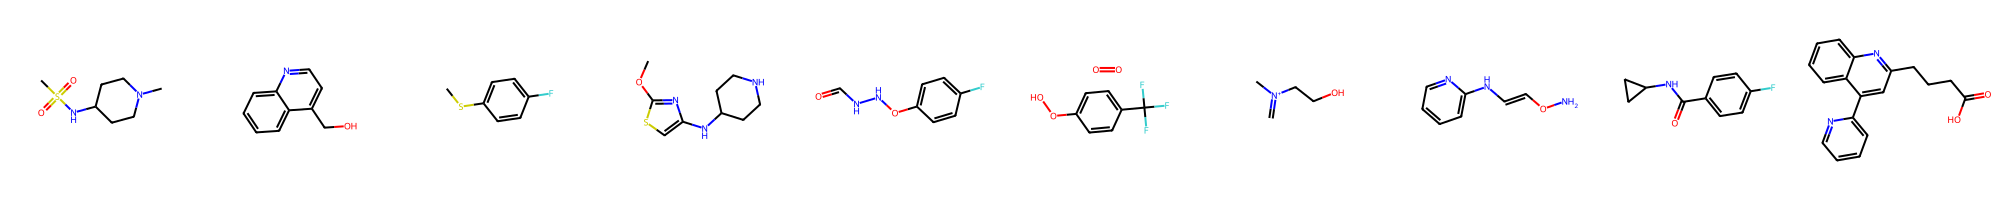

In [40]:
img = Draw.MolsToGridImage([decoding_res[i].molecule for i in range(len(decoding_res))], subImgSize=(200,200), maxMols = 1000, molsPerRow=10,)
img

# Con VAE

In [16]:
ckpt_path_con = '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_09.756251/epochepoch=99-dropout=0.95-val_lossval/loss=0.43.ckpt'
ckpt_con = torch.load(ckpt_path_con, map_location = device)

In [15]:
config_file_con = '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_09.756251/logs_2023-05-04_12_17_09.756251/version_0/ddim_vae_con.yml'
config_con = OmegaConf.load(config_file_con)
ldm_params_con = config_con['model']['params']

In [43]:
# first_stage_params = get_params(dataset)
first_stage_config = config_con['model']['first_stage_config']
ldm_params_con = config_con['model']['params']
unet_params_con = config_con['model']['unet_config']['params']
unet_params_con

{'use_spatial_transformer': True, 'image_size': 512, 'in_channels': 1, 'out_channels': 1, 'model_channels': 64, 'dims': 1, 'attention_resolutions': [4, 2], 'num_res_blocks': 1, 'channel_mult': [1, 2, 3], 'context_dim': 979, 'num_head_channels': 8}

In [44]:
con_vae_ldm = LatentDiffusion(
    first_stage_config,
    config_con['model']['cond_stage_config'],
    dataset, 
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config_con['model']['unet_config'],
    **ldm_params_con
)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 8.91 M params.


In [57]:
con_vae_ldm.model.conditioning_key

'crossattn'

In [46]:
cond_sampler = MolSampler(con_vae_ldm)
cond_sampler

In [51]:
n_samples = 10
ge = one.gene_expressions[:n_samples,]
ge.size()

torch.Size([10, 978])

In [53]:
dose = one.dose[:n_samples]
cond = torch.cat((ge, dose.unsqueeze(-1)), dim=1)
cond.size()

torch.Size([10, 979])

In [54]:
conditioning = cond.view((n_samples, 1, unet_params_con.context_dim))
conditioning.size()

torch.Size([10, 1, 979])

In [59]:
samples, _ = cond_sampler.sample(
    S = ddim_steps,
    batch_size = n_samples,  # not batch size
    conditioning = conditioning,
    shape = size,
    ddim_eta = ddim_eta
)

samples

Selected timesteps for ddim sampler: [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9946, 0.9904, 0.9859, 0.9810, 0.9756, 0.9698, 0.9635, 0.9568,
        0.9496, 0.9418, 0.9336, 0.9249, 0.9157, 0.9060, 0.8958, 0.8851, 0.8739,
        0.8622, 0.8500, 0.8373, 0.8241, 0.8105, 0.7964, 0.7819, 0.7670, 0.7516,
        0.7359, 0.7198, 0.7034, 0.6867, 0.6697, 0.6524, 0.6350, 0.6173, 0.5994,
        0.5814, 0.5633, 0.5451, 0.5269, 0.5087, 0.4905, 0.4724, 0.4543, 0.4364,
        0.4186, 0.4011, 0.3837, 0.3666, 0.3497]); a_(t-1): [0.99914998 0.99827701 0.99455011 0.99043489 0.98591566 0.98097759
 0.97560668 0.96978998 0.96351564 0.95677292 0.9495523  0.9418456
 0.93364584 0.92494762 0.91574699 0.90604162 0.89583057 0.88511467
 0.8738966  0.86218047 0.84997231 0.83727998 0.82411301 0.810

DDIM Sampler: 100%|█████████████████████████████████| 50/50 [00:04<00:00, 11.89it/s]


tensor([[[ 2.9230,  0.9639,  0.8896,  ..., -1.6340, -1.3932,  2.2602]],

        [[-1.9903,  0.2114,  3.4649,  ..., -1.0343, -0.6143,  0.9352]],

        [[-2.0824, -0.3528, -0.9906,  ..., -2.4339, -0.4103,  0.6103]],

        ...,

        [[-1.6943, -0.7312, -0.3463,  ...,  0.9638,  1.8966,  1.0553]],

        [[-1.6840, -0.4978, -3.1969,  ..., -1.5958, -0.6262, -2.1530]],

        [[-2.2317,  0.8837,  2.4200,  ..., -2.9354,  1.5370, -0.2774]]])

In [60]:
samples.size()

torch.Size([10, 1, 512])

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

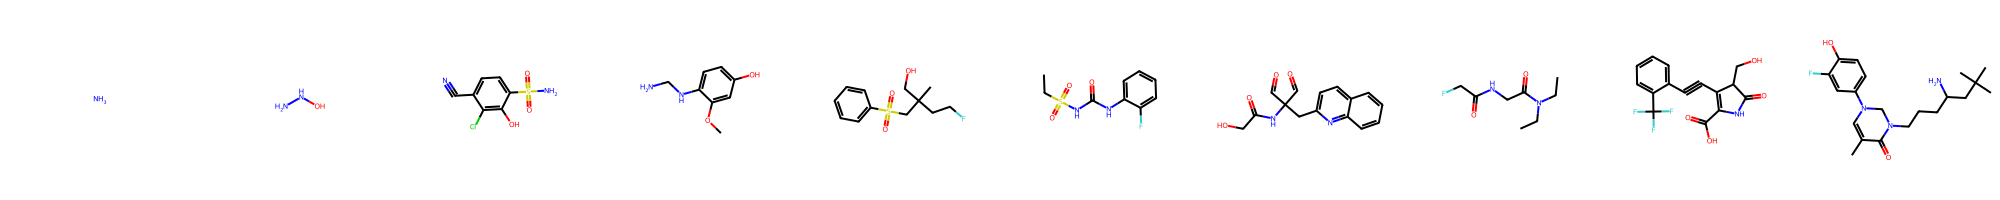

In [61]:
decoding_samples = samples.view((n_samples, unet_params_con.image_size))
decoding_res = con_vae_ldm.first_stage_model.decode(decoding_samples)
img = Draw.MolsToGridImage([decoding_res[i].molecule for i in range(len(decoding_res))], subImgSize=(200,200), maxMols = 1000, molsPerRow=10,)
img

# Uncon AAE

In [6]:
from ldm.moler_ldm import LatentDiffusion
from ldm.DDIM import MolSampler
import time

In [7]:
ckpt_path_aae = 'lightning_logs/2023-05-12_11_35_19.568394/epoch=24-step=944999.0-val_loss=0.13.ckpt'
ckpt_aae = torch.load(ckpt_path_aae, map_location = device)

In [8]:
config_file_aae = 'config/ldm_uncon+aae_uncon.yml'
config_aae = OmegaConf.load(config_file_aae)
# ldm_params = config_aae['model']['params']

In [9]:
dataset = MolerDataset(
    root="/data/ongh0068",
    raw_moler_trace_dataset_parent_folder="/data/ongh0068/guacamol/trace_dir",
    output_pyg_trace_dataset_parent_folder="/data/ongh0068/l1000/already_batched",
    split="valid_0",
)

In [10]:
first_stage_params = get_params(dataset)
first_stage_config = config_aae['model']['first_stage_config']
ldm_params = config_aae['model']['params']
unet_params = config_aae['model']['unet_config']['params']
batch_size = 1
drop_prob = 0.0
latent_space_dim = int(ldm_params['image_size'])
size = [1, latent_space_dim]

In [11]:
model = LatentDiffusion(
    first_stage_config,
    config_aae['model']['cond_stage_config'],
    dataset, 
    drop_prob,
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config_aae['model']['unet_config'],
    **ldm_params
)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 3.49 M params.


In [12]:
model.load_state_dict(ckpt_aae['state_dict'])
model = model.to(device)
model.eval()

LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (1): TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=256, out_features=64, bias=True)
            )
            (out_layers): Sequential(
              (0): GroupNorm32(32, 64, e

In [13]:
sampler = MolSampler(model)
number_samples = 20
internal_bs = 20
steps = int(number_samples / internal_bs)
size = [1, latent_space_dim]
ddim_steps = 200
ddim_eta = 1.0

In [14]:
start_time = time.time()

for step in tqdm(range(steps)):
    z_samples, _ = sampler.sample(
        S = ddim_steps,
        batch_size = internal_bs,  # not batch size
        shape = size,
        ddim_eta = ddim_eta
    )
    if step == 0:
        z = z_samples.view((internal_bs, latent_space_dim))
    else:
        tmp_z = z_samples.view((internal_bs, latent_space_dim))
        z = torch.cat((z, tmp_z), dim = 0)
# print("z shape: ", self.z.shape)
print("Finished sampling z")
z_time = time.time()

# decoder_states = model.first_stage_model.decode(
#     latent_representations=z, max_num_steps=120
# )
# decoder_states = decoder_states.cpu()
# self.release_gpu_memory(self.model, self.ckpt)
# self.samples = [
#     Chem.MolToSmiles(decoder_state.molecule) for decoder_state in decoder_states
# ]

end_time = time.time()

  0%|                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]

Selected timesteps for ddim sampler: [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355
 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445
 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535
 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625
 630 635 640 645 650 655 660 665 670 675 680 685 690 695 700 705 710 715
 720 725 730 735 740 745 750 755 760 765 770 775 780 785 790 795 800 805
 810 815 820 825 830 835 840 845 850 855 860 865 870 875 880 885 890 895
 900 905 910 915 920 925 930 935 940 945 950 955 960 965 970 975 980 985
 990 995]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9948, 0.9904, 0.9859, 0.9813, 0.9766, 0.9718, 0.9669, 0.9619,
        0.9568, 0.9516, 0.9463,


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.96s/it]

Finished sampling z


In [90]:
print(z_time - start_time)
print(end_time - z_time)
print(end_time - start_time)

119.19239568710327
1.5735626220703125e-05
119.19241142272949


In [15]:
z.shape

torch.Size([20, 512])

In [16]:
decoder_states = model.first_stage_model.decode(
    latent_representations=z, max_num_steps=120
)
decoder_states[0]

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

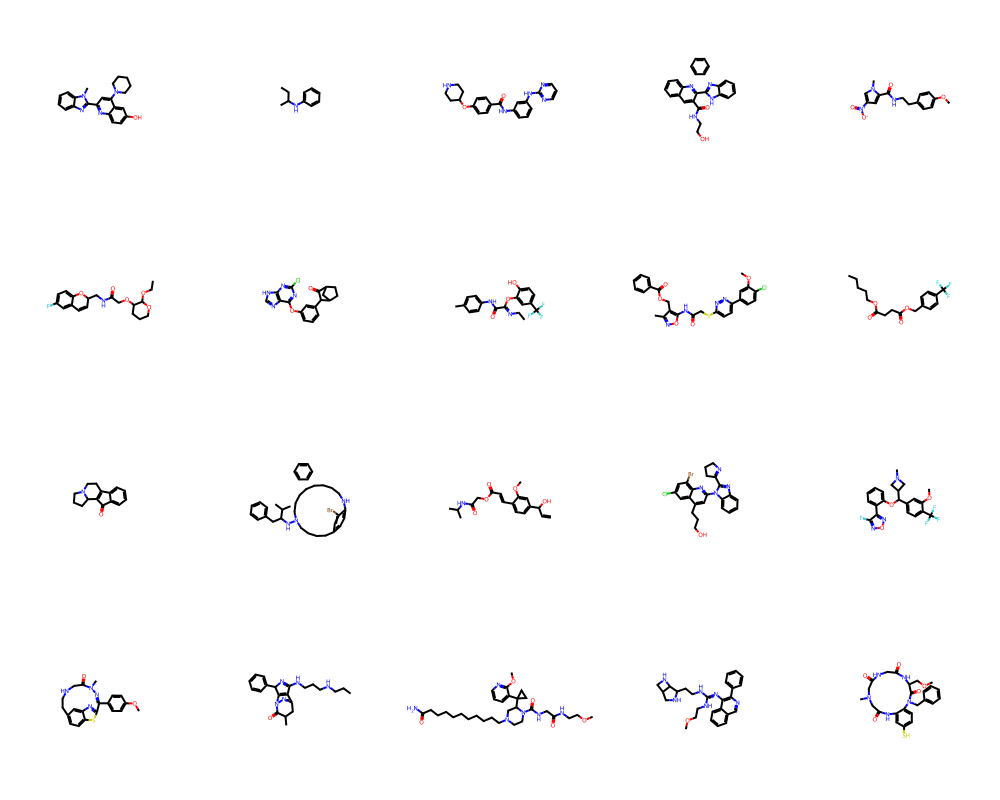

In [48]:
Draw.MolsToGridImage([decoder_states[i].molecule for i in range(len(decoder_states))], subImgSize=(200,200), maxMols = 1000, molsPerRow=5)

### Check chiral center

In [14]:
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from rdkit.Chem import rdCIPLabeler

In [18]:
opts = StereoEnumerationOptions(unique=True)

for state in decoder_states:
    mol = state.molecule
    isomers = tuple(EnumerateStereoisomers(mol, options=opts))
    print(len(isomers))

1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
2
1


#### check one of them
- COC1=CC(C(OC2=CC=CC=C2C2=NON=C2F)C2CN(C)C2)=CC=C1C(F)(F)F
- have two isomers but they are the same

In [11]:
smiles = 'COC1=CC(C(OC2=CC=CC=C2C2=NON=C2F)C2CN(C)C2)=CC=C1C(F)(F)F'

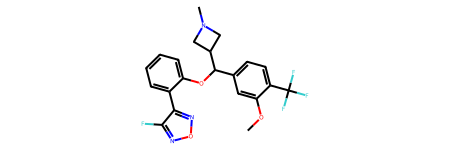

In [12]:
m = Chem.MolFromSmiles(smiles)
m

In [15]:
isomers = tuple(EnumerateStereoisomers(m))
len(isomers)

2

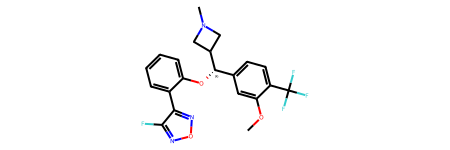

In [16]:
isomers[0]

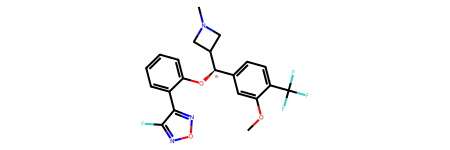

In [17]:
isomers[1]

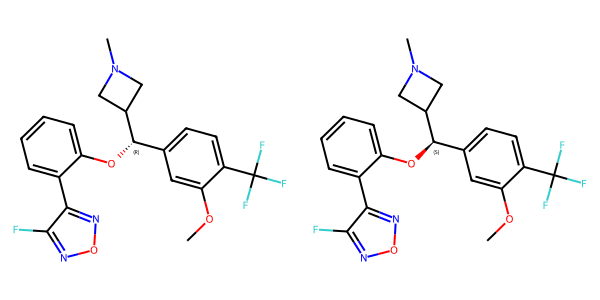

In [18]:
Draw.MolsToGridImage(isomers, subImgSize=(300,300), maxMols = 1000, molsPerRow=2)

In [29]:
mol = decoder_states[-8].molecule
opts = StereoEnumerationOptions(unique=True)
isomers = tuple(EnumerateStereoisomers(mol, options=opts))
len(isomers)

2

In [30]:
for smi in sorted(Chem.MolToSmiles(x, isomericSmiles=True) for x in isomers):
    print(smi)

C=CC(O)C1=CC=C(/C=C/C(=O)OCC(=O)NC(C)C)C(OC)=C1
C=CC(O)C1=CC=C(/C=C\C(=O)OCC(=O)NC(C)C)C(OC)=C1


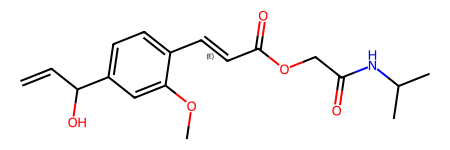

In [31]:
iso0 = isomers[0]
rdCIPLabeler.AssignCIPLabels(iso0)
iso0

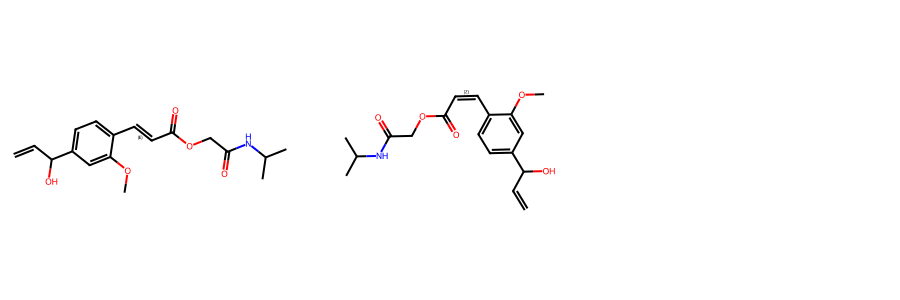

In [34]:
# opts = Draw.MolDrawOptions()
# opts.bondLineWidth = 0.5
Draw.MolsToGridImage([isomers[i] for i in range(len(isomers))], subImgSize=(300,300), maxMols = 1000, molsPerRow=3, useSVG=True)

- find chiral centers returns nothing?

In [23]:
Chem.FindMolChiralCenters(mol)

[]

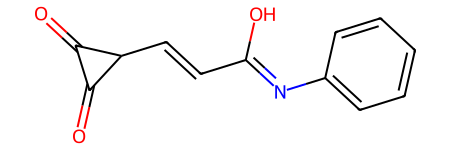

In [24]:
rdCIPLabeler.AssignCIPLabels(mol)
mol

In [45]:
mol2 = decoder_states[-3].molecule
Chem.FindMolChiralCenters(mol2)


[]

In [53]:
samples = [decoder_states[i].molecule for i in range(7,16)]
samples[4] = decoder_states[-2].molecule



In [54]:
# samples[0, 4, 5] have isomers
m1 = samples[0]
m2 = samples[4]
m3 = samples[5]

opts = StereoEnumerationOptions(unique=True)
iso1 = tuple(EnumerateStereoisomers(m1, options=opts))
iso2 = tuple(EnumerateStereoisomers(m2, options=opts))
iso3 = tuple(EnumerateStereoisomers(m3, options=opts))

for smi in sorted(Chem.MolToSmiles(x, isomericSmiles=True) for x in iso1):
    print(smi)
for smi in sorted(Chem.MolToSmiles(x, isomericSmiles=True) for x in iso2):
    print(smi)
for smi in sorted(Chem.MolToSmiles(x, isomericSmiles=True) for x in iso3):
    print(smi)

CC/N=C(/OC1=CC(C(F)(F)F)=CC=C1O)C(=O)NC1=CC=C(C)C=C1
CC/N=C(\OC1=CC(C(F)(F)F)=CC=C1O)C(=O)NC1=CC=C(C)C=C1
COCCN/C(=N/C1=C(C2=CC=CC=C2)N=CC2=CC=CC=C21)NCCC1NCC2CNC21
COCCN/C(=N\C1=C(C2=CC=CC=C2)N=CC2=CC=CC=C21)NCCC1NCC2CNC21
C=CC(O)C1=CC=C(/C=C/C(=O)OCC(=O)NC(C)C)C(OC)=C1
C=CC(O)C1=CC=C(/C=C\C(=O)OCC(=O)NC(C)C)C(OC)=C1


In [57]:
samples[0] = iso1[0]
samples[4] = iso2[1]
samples[5] = iso3[1]


for m in samples:
    smi = Chem.MolToSmiles(m)
    print(smi)

CC/N=C(/OC1=CC(C(F)(F)F)=CC=C1O)C(=O)NC1=CC=C(C)C=C1
COC1=CC(C2=CC=C(SCC(=O)NC3=C(COC(=O)C4=CC=CC=C4)C(C)=NO3)N=N2)=CC=C1Cl
CCCCCOC(=O)CCC(=O)OCC1=CC=C(C(F)(F)F)C=C1
O=C1C2=CC=CC=C2C2=C1C1CCCN1CC2
COCCN/C(=N\C1=C(C2=CC=CC=C2)N=CC2=CC=CC=C21)NCCC1NCC2CNC21
C=CC(O)C1=CC=C(/C=C\C(=O)OCC(=O)NC(C)C)C(OC)=C1
OCCCC1=CC(N2C3=CC=CC=C3N=C2C2=NCCC2)=NC2=C(Br)C=C(Cl)C=C12
COC1=CC(C(OC2=CC=CC=C2C2=NON=C2F)C2CN(C)C2)=CC=C1C(F)(F)F
COC1=CC=C(C2=NN(C)C(=O)CNCCC3=CC=C4SC2=NC4=C3)C=C1


In [58]:
smiles_list = [Chem.MolToSmiles(m) for m in samples]
pd.DataFrame(smiles_list).to_csv('../molecule_imgs/chiral_9_sample_smiles.txt', header=None, index=False)

#### Load the example molecules 

In [10]:
sample_smis = pd.read_csv('../molecule_imgs/chiral_9_sample_smiles.txt', header=None)
sample_smis = sample_smis.values.squeeze().tolist()
sample_smis

['CC/N=C(/OC1=CC(C(F)(F)F)=CC=C1O)C(=O)NC1=CC=C(C)C=C1',
 'COC1=CC(C2=CC=C(SCC(=O)NC3=C(COC(=O)C4=CC=CC=C4)C(C)=NO3)N=N2)=CC=C1Cl',
 'CCCCCOC(=O)CCC(=O)OCC1=CC=C(C(F)(F)F)C=C1',
 'O=C1C2=CC=CC=C2C2=C1C1CCCN1CC2',
 'COCCN/C(=N\\C1=C(C2=CC=CC=C2)N=CC2=CC=CC=C21)NCCC1NCC2CNC21',
 'C=CC(O)C1=CC=C(/C=C\\C(=O)OCC(=O)NC(C)C)C(OC)=C1',
 'OCCCC1=CC(N2C3=CC=CC=C3N=C2C2=NCCC2)=NC2=C(Br)C=C(Cl)C=C12',
 'COC1=CC(C(OC2=CC=CC=C2C2=NON=C2F)C2CN(C)C2)=CC=C1C(F)(F)F',
 'COC1=CC=C(C2=NN(C)C(=O)CNCCC3=CC=C4SC2=NC4=C3)C=C1']

In [23]:
samples = [Chem.MolFromSmiles(smi) for smi in sample_smis]
samples[-2] = isomers[1]

In [24]:
IPythonConsole.drawOptions.baseFontSize = 1.3

In [25]:
leg = list(range(1, 10))
leg = [str(i) for i in leg]
leg

['1', '2', '3', '4', '5', '6', '7', '8', '9']

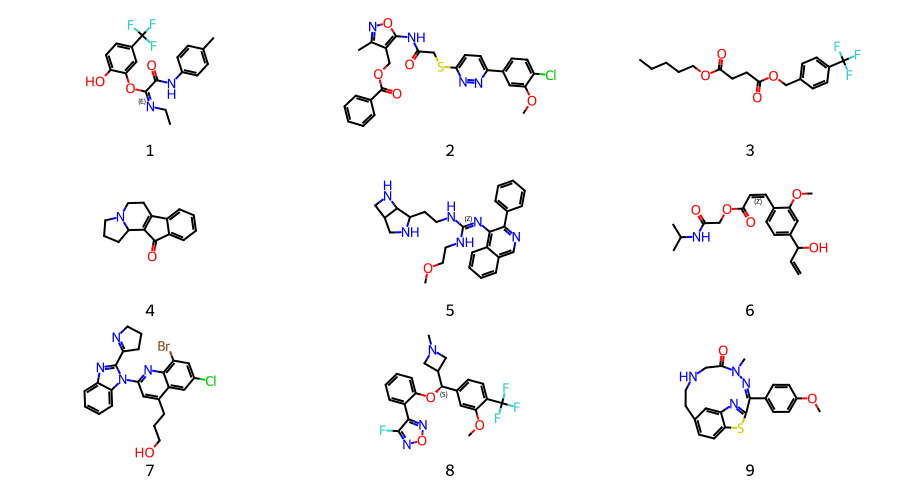

In [26]:
svg = Draw.MolsToGridImage(samples, legends=leg, subImgSize=(300,160), maxMols = 1000, molsPerRow=3, useSVG=True)
img = Draw.MolsToGridImage(samples, legends=leg, subImgSize=(300,160), maxMols = 1000, molsPerRow=3)
img

In [27]:
with open('../molecule_imgs/uncond_generation/chiral_aae.svg', 'w') as f:
    f.write(svg.data)

In [92]:
from rdkit.Chem.Draw import rdMolDraw2D
import io
import base64
from PIL import Image
drawer = rdMolDraw2D.MolDraw2DSVG(900, 450, 300, 150)
# rdMolDraw2D.MolDraw2DSVG.SetFontSize(drawer, 20)
opts = drawer.drawOptions()
opts.addStereoAnnotation = True
opts.minFontSize = 13
drawer.DrawMolecules(samples)
drawer.FinishDrawing()
data_str = drawer.GetDrawingText()

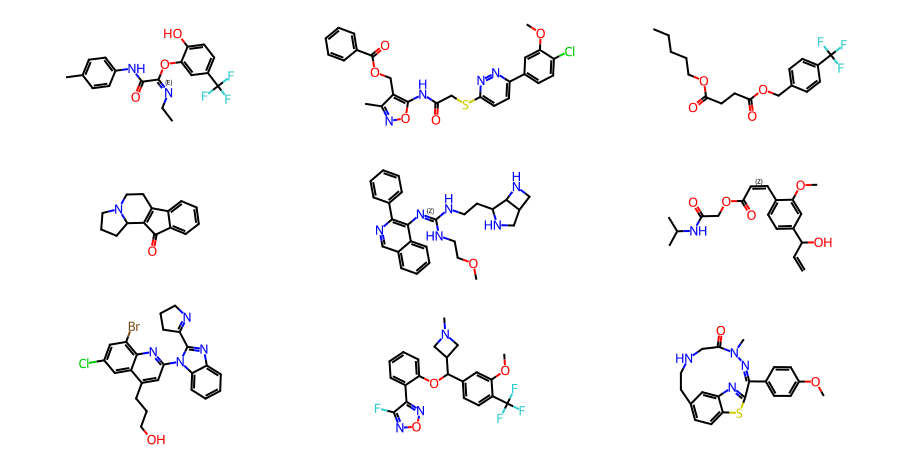

In [101]:
%matplotlib inline
import IPython.display
i = IPython.display.SVG(data_str)
display(i)

In [100]:
# resolution becomes low again when converting to png in this way!!!
import cairosvg
import tempfile

with tempfile.NamedTemporaryFile(delete=True) as tmp:
    tmp.write(data_str.encode())
    tmp.flush()
    cairosvg.svg2png(url=tmp.name, write_to="../molecule_imgs/uncond_generation/chiral_aae.png")

In [95]:

drawer = rdMolDraw2D.MolDraw2DCairo(900, 450, 300, 150)
# rdMolDraw2D.MolDraw2DSVG.SetFontSize(drawer, 20)
opts = drawer.drawOptions()
opts.addStereoAnnotation = True
opts.minFontSize = 13
drawer.DrawMolecules(samples)
drawer.FinishDrawing()
# data_str = drawer.GetDrawingText()
drawer.WriteDrawingText('../molecule_imgs/uncond_generation/chiral_aae.png')

## Check every t step

In [58]:
sampler = MolSampler(model)
number_samples = 1
internal_bs = 1
steps = int(number_samples / internal_bs)
size = [1, latent_space_dim]
ddim_steps = 1000
ddim_eta = 1.0

In [59]:
start_time = time.time()

for step in tqdm(range(steps)):
    z_samples, intermediates = sampler.sample(
        S = ddim_steps,
        batch_size = internal_bs,  # not batch size
        shape = size,
        ddim_eta = ddim_eta,
        log_every_t = 200
    )
    if step == 0:
        z = z_samples.view((internal_bs, latent_space_dim))
    else:
        tmp_z = z_samples.view((internal_bs, latent_space_dim))
        z = torch.cat((z, tmp_z), dim = 0)
# print("z shape: ", self.z.shape)
print("Finished sampling z")
z_time = time.time()

  0%|                                                   | 0/1 [00:00<?, ?it/s]

Selected timesteps for ddim sampler: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 2


DDIM Sampler:  60%|██████████████▎         | 598/1000 [00:22<00:15, 26.26it/s]


100%|███████████████████████████████████████████| 1/1 [00:37<00:00, 37.58s/it]

Finished sampling z


In [60]:
intermediates.keys()

dict_keys(['x_inter', 'pred_x0'])

In [61]:
len(intermediates['pred_x0'])

7

In [62]:
len(intermediates['x_inter'])

7

In [17]:
z.shape

torch.Size([1, 512])

In [18]:
intermediates['pred_x0'][0].size()

torch.Size([1, 1, 512])

In [19]:
intermediates['x_inter'][0].size()

torch.Size([1, 1, 512])

should not use pred x0

In [20]:
pred_x0 = [tensor.view((internal_bs, latent_space_dim)) for tensor in intermediates['pred_x0']]
pred_x0.append(z)
pred_x0

[tensor([[ 6.5515e-01,  1.7541e-01,  6.4688e-01, -6.9200e-01, -9.6116e-02,
          -4.6802e-01, -3.3664e-03, -6.4685e-01, -3.7628e-02,  3.0235e-01,
          -1.8024e+00, -1.1667e+00,  8.9238e-01,  1.4635e+00,  1.0362e-01,
           2.2049e-01,  1.3826e+00, -2.1957e-01,  1.3092e+00, -9.0257e-01,
          -4.0885e-01,  4.2789e-01,  6.2951e-01, -1.0788e+00, -1.8487e+00,
           1.2285e+00,  3.3335e-01, -1.0413e+00,  1.9183e-01, -1.7396e+00,
           1.6893e+00,  2.2172e-01,  4.0883e-01,  3.4411e-01,  1.0527e+00,
           1.5754e+00, -4.5406e-01, -1.8664e+00, -9.3881e-01,  3.0293e-01,
          -1.6545e+00,  1.1752e+00,  1.1367e+00, -4.5311e-01,  2.3347e-01,
          -7.0661e-01,  8.6815e-01, -7.6510e-02,  6.9873e-01, -1.0246e+00,
           1.0521e+00,  1.5414e+00,  7.8057e-01,  1.7504e+00, -1.5301e+00,
          -4.1694e-02, -9.0690e-01,  9.0192e-01,  6.8896e-01,  1.2084e-01,
          -7.8072e-01, -6.0993e-01,  6.5131e-01,  1.3636e+00, -1.2969e-01,
          -4.5083e-01,  3

In [21]:
pred_x0_tensor = torch.Tensor()
for i in range(len(pred_x0)):
    if i == 0:
        pred_x0_tensor = pred_x0[0]
    else: 
        pred_x0_tensor = torch.cat((pred_x0_tensor, pred_x0[i]), dim=0)

In [29]:
pred_x0_tensor

tensor([[ 0.6551,  0.1754,  0.6469,  ..., -0.4557, -1.3383,  0.9721],
        [-0.1181, -0.0751,  0.0406,  ...,  0.0186, -0.7763, -1.0670],
        [ 0.0572, -0.0666,  0.2221,  ...,  0.0163, -0.8389, -0.7659],
        ...,
        [ 0.1501,  0.1015,  0.4512,  ..., -0.1553, -1.2045, -0.2598],
        [ 0.1495,  0.1341,  0.4955,  ..., -0.1484, -1.2734, -0.1687],
        [ 0.1636,  0.1341,  0.4982,  ..., -0.1526, -1.2870, -0.1661]],
       device='cuda:0')

In [23]:

pred_x0_decode = model.first_stage_model.decode(
    latent_representations=pred_x0_tensor, max_num_steps=120
)

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

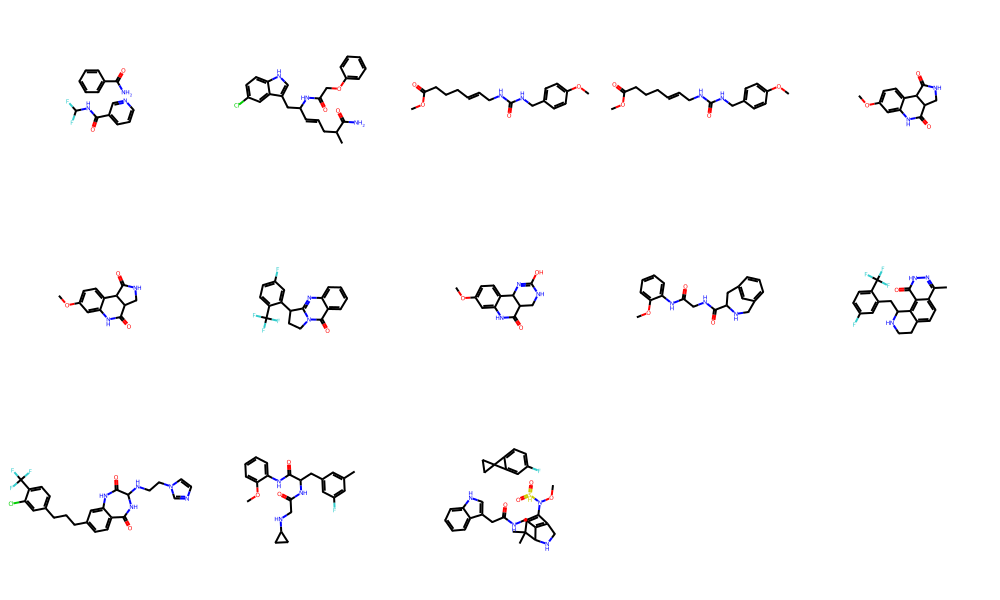

In [24]:
from rdkit.Chem import Draw

img = Draw.MolsToGridImage([pred_x0_decode[i].molecule for i in range(len(pred_x0_decode))], subImgSize=(200,200), maxMols = 1000, molsPerRow=5,)
img

In [63]:
x_inter = [tensor.view((internal_bs, latent_space_dim)) for tensor in intermediates['x_inter']]
x_inter.append(z)

x_inter_tensor = torch.Tensor()
for i in range(len(x_inter)):
    if i == 0:
        x_inter_tensor = x_inter[0]
    else: 
        x_inter_tensor = torch.cat((x_inter_tensor, x_inter[i]), dim=0)
        
x_inter_decode = model.first_stage_model.decode(
    latent_representations=x_inter_tensor, max_num_steps=120
)

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

In [64]:
x_inter

[tensor([[-0.1050,  1.3373,  0.1856, -2.2092,  0.5561, -0.3233, -0.7429, -1.6700,
           0.6949,  0.4669,  0.7619, -0.2817,  0.6187,  0.6508, -1.7076, -1.5707,
          -0.3245, -0.3610,  0.4009, -1.0314,  0.9815, -1.2564, -1.0282,  0.0989,
          -0.2942,  0.1772,  0.2298, -0.1053, -0.1811, -0.3520, -1.3356,  0.4449,
           0.5299, -0.5402,  0.5681,  0.4048, -0.7596,  1.0650, -0.3396, -1.3049,
          -0.7395, -0.4360,  0.6834,  0.0764, -0.7766, -0.5448, -0.1956,  1.4096,
          -0.7286,  0.9224,  0.4953, -0.1686,  1.1163, -1.7725, -0.2153, -0.4417,
           1.8614,  1.7960, -0.9445, -0.0897,  0.7819, -0.9085, -0.6086, -1.4867,
           1.3443, -1.7412, -1.4395,  1.6546,  0.2170,  0.3037, -0.4257, -1.6002,
          -1.3571, -1.2405, -1.7621, -0.0811,  0.3182, -0.7180,  0.9803,  0.6758,
           0.4682,  0.7642, -2.0103,  0.9300,  0.8579,  1.1019, -0.9184,  0.0182,
          -0.3254, -1.0838, -0.4132, -2.1357,  1.0700,  1.2775, -0.8982, -1.4180,
           0.867

In [65]:
x_inter_tensor

tensor([[-0.1050,  1.3373,  0.1856,  ...,  1.2186,  0.6101, -0.3182],
        [-0.1050,  1.3372,  0.1857,  ...,  1.2184,  0.6097, -0.3185],
        [-0.0840,  1.3104,  0.2106,  ...,  1.1704,  0.4831, -0.3882],
        ...,
        [ 0.3277,  0.8440,  0.3247,  ...,  0.4801, -0.2558, -0.5785],
        [ 0.2015,  0.3430,  0.3024,  ...,  0.0227, -0.6527, -0.6179],
        [ 0.2015,  0.3430,  0.3024,  ...,  0.0227, -0.6527, -0.6179]],
       device='cuda:0')

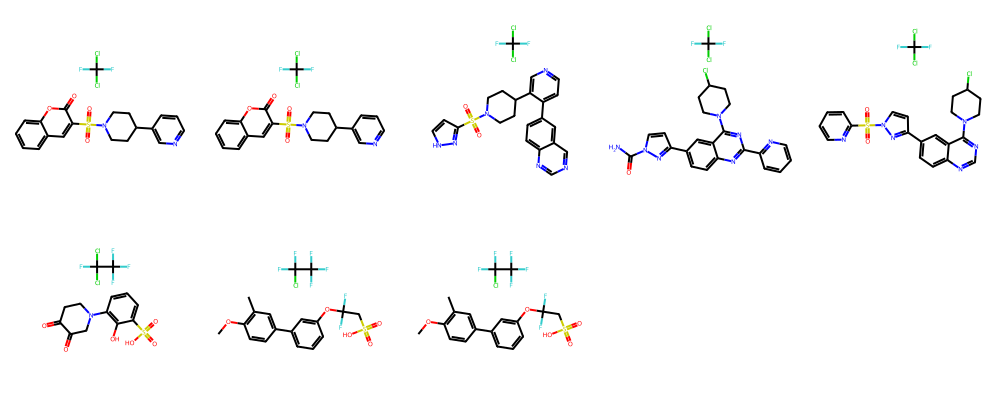

In [66]:
from rdkit.Chem import Draw

img = Draw.MolsToGridImage([x_inter_decode[i].molecule for i in range(len(x_inter_decode))], subImgSize=(200,200), maxMols = 1000, molsPerRow=5,)
img